In [49]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import shapely

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


In [78]:
infrastructure = pd.read_csv('../data/spatial-data/infrastructure.csv')
infrastructure['place_type'].value_counts()

supermarket        2195
train station      1983
market             1509
police station      756
shopping centre     664
hospital            528
tram stop           412
Name: place_type, dtype: int64

### 1. Load data

In [46]:
# shapefile
sf = gpd.read_file('../data/landing/SA2_2021_AUST_GDA2020.shp')
sf = sf[sf['STE_NAME21'] == 'Victoria']
sf = sf[['SA2_NAME21', 'AREASQKM21', 'geometry']]
sf = sf.iloc[:-2, :]
sf.columns = ['sa2', 'area', 'geometry']
sf['sa2'] = sf['sa2'].apply(lambda x: x.lower())

# 7844
gdf = sf.to_crs(epsg=2263)
gdf['centroid'] = gdf.centroid
gdf = gdf.to_crs(epsg=7844)
gdf["centroid"] = gdf["centroid"].to_crs(epsg=7844)
gdf = gdf.sort_values(by='sa2').reset_index(drop=True)

# sa2 data
sa2_data = pd.read_csv('../data/curated/sa2_data_by_year.csv')

+ Data Enconding and Scaling

In [55]:
# encoding
SA2_ENCODER = LabelEncoder()
SA2_ENCODER.fit(['other state'] + sa2_data['sa2'].to_list())
sa2_data['sa2'] = SA2_ENCODER.transform(sa2_data['sa2'])

# scaling
sa2_scaled = StandardScaler().fit_transform(sa2_data)
sa2_scaled = pd.DataFrame(sa2_scaled, columns=sa2_data.columns)
sa2_scaled

,sa2,year,income,population_density,crime_density,rent,cluster_label
0,-1.726541,-1.549193,0.520813,1.155753,1.071113,0.669918,1.087664
1,-1.719921,-1.549193,-0.026037,0.126446,0.198815,-0.358688,-0.813320
2,-1.713301,-1.549193,1.591465,0.672753,-0.243250,0.808968,1.087664
3,-1.706681,-1.549193,-1.832485,-0.700012,-0.433774,-0.535188,-0.813320
4,-1.700061,-1.549193,-0.337315,-0.617428,-0.426129,-1.415841,-0.813320
...,...,...,...,...,...,...,...
4693,1.702496,1.549193,-0.893259,-0.700054,-0.433778,0.044190,-0.813320
4694,1.709116,1.549193,3.198077,0.449905,-0.041866,1.133420,1.087664
4695,1.715736,1.549193,-0.229256,-0.663706,-0.429496,0.113715,-0.813320
4696,1.722356,1.549193,0.818550,-0.700630,-0.433775,-0.442487,1.087664


### 2. Model

+ Grid search for best hyperparram of Agglometrative Clustering

In [5]:
N_CLUSTER = range(2, 20)
LINKAGE =  ['ward', 'complete', 'average', 'single']
cluster_models = {link: [] for link in LINKAGE}
for link in LINKAGE:
    for n in N_CLUSTER:
        print(n)
        agc = AgglomerativeClustering(n_clusters=n, linkage=link)
        agc.fit(sa2_scaled)
        cluster_models[link].append(agc)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [6]:
cluster_score = {link: [] for link in LINKAGE}
for link in LINKAGE:
    for model in cluster_models[link]:
        cluster_score[link].append(silhouette_score(sa2_scaled, model.labels_))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

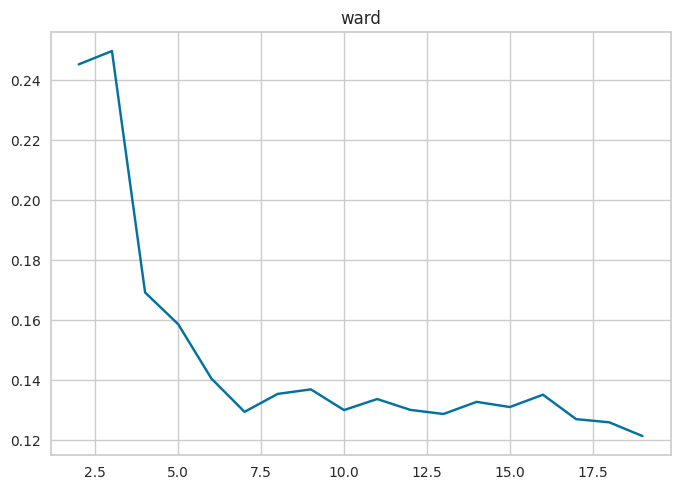

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

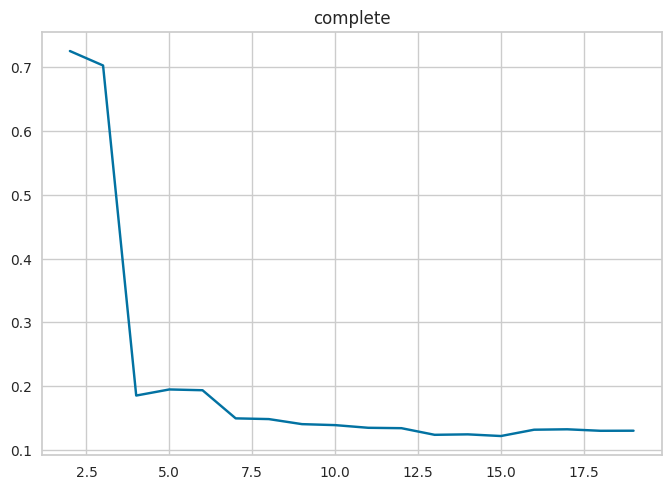

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

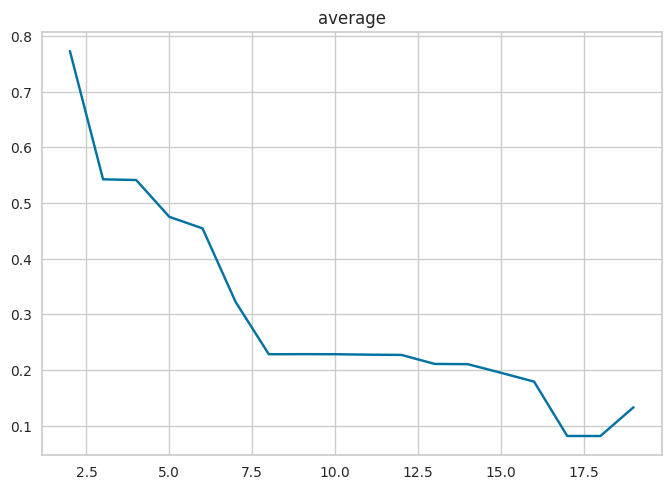

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

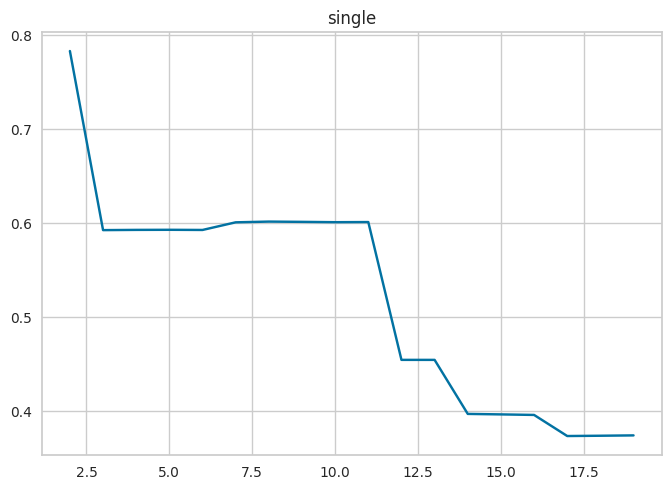

,ward,complete,average,single
0,0.245115,0.724992,0.772869,0.783084
1,0.249540,0.702342,0.542343,0.592541
2,0.169209,0.185496,0.541096,0.592790
3,0.158636,0.195054,0.474913,0.592885
4,0.140581,0.193826,0.454208,0.592716
5,0.129504,0.149785,0.321799,0.600841
6,0.135475,0.148648,0.228085,0.601619
7,0.136977,0.140737,0.228244,0.601333
8,0.130090,0.139197,0.228116,0.600984
9,0.133766,0.135010,0.227305,0.601124


In [7]:
for link in LINKAGE:
    plt.plot(N_CLUSTER, cluster_score[link])
    plt.title(link)
    plt.show()
pd.DataFrame(cluster_score)

In [8]:
def plot_dendrogram(model, **kwargs):
    # dendrogram plot function from sklearn
    
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [9]:
# for link in LINKAGE:
#     for n in N_CLUSTER:
#         model = cluster_models[link][n - 3]
#         plt.title(f"Hierarchical Clustering Dendrogram {link} {n}")
#         plot_dendrogram(model, truncate_mode="level", p=3)
#         plt.show()

+ Grid search for best hyperparram of Kmeans Clustering

In [10]:
km_model = []
for n in N_CLUSTER:
    knn = KMeans(n_clusters=n)
    knn.fit(sa2_scaled)
    km_model.append(knn)

In [11]:
km_score = []
for model in km_model:
        km_score.append(silhouette_score(sa2_scaled, model.labels_))

[0.25376681868437606,
 0.26159852897148167,
 0.21201886384170096,
 0.1986593275291925,
 0.20685300695443062,
 0.19350215111315136,
 0.19712908826875158,
 0.18697072290574845,
 0.18386919440438348,
 0.18735255553893296,
 0.18129530542743447,
 0.17342205691236232,
 0.17772621962276583,
 0.17465571237928948,
 0.1804060740341294,
 0.17967236019349336,
 0.174361597394482,
 0.1721596919404784]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

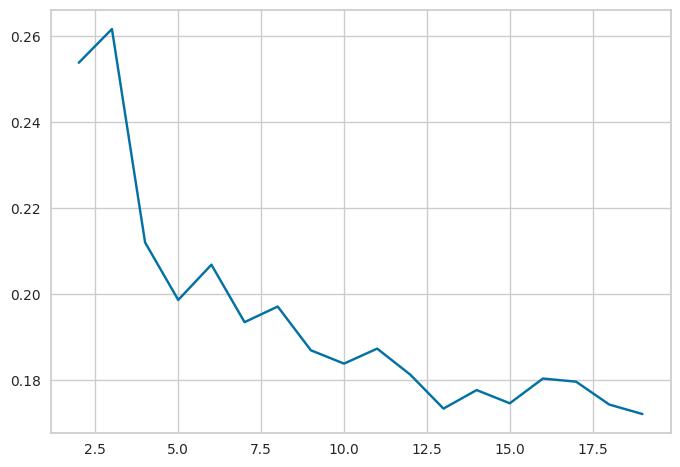

In [48]:
plt.plot(N_CLUSTER, km_score)
km_score

+ Selected Agglomerative Clustering with 3 cluster

In [58]:
CLR = AgglomerativeClustering(n_clusters=3)
CLR.fit(sa2_scaled)
sa2_data['cluster_label'] = CLR.labels_
sa2_data['cluster_label'].value_counts()

0    2763
1    1860
2      75
Name: cluster_label, dtype: int64

In [44]:
income = pd.read_csv('../data/mapped/mapped_income.csv')
rent = pd.read_csv('../data/mapped/mapped_rent_av.csv')
crime = pd.read_csv('../data/mapped/mapped_crime.csv')
population = pd.read_csv('../data/mapped/mapped_population.csv')

### 3. Predicting

+ Fit a linear model for each of SA2 feature: income, rent, crime density, population density

In [60]:
lr_model = {}
for item in ['income', 'rent', 'crime_density', 'population_density']:
    x = sa2_data[['sa2', 'year', 'cluster_label']]
    y = sa2_data[item]
    reg = LinearRegression().fit(x, y)
    lr_model[item] = reg

In [63]:
income_lr = LinearRegression().fit(sa2_data[['sa2', 'year']], sa2_data['income'])
population_lr = LinearRegression().fit(sa2_data[['sa2', 'year']], sa2_data['population_density'])
crime_lr = LinearRegression().fit(sa2_data[['sa2', 'year']], sa2_data['crime_density'])
rent_lr = LinearRegression().fit(sa2_data[['sa2', 'year']], sa2_data['rent'])

+ Predict the data to 2028

In [64]:
SA2 = sorted(sa2_data['sa2'].unique())
year = [y for y in range(2024, 2029) for i in range(len(SA2)) ]
future = pd.DataFrame({'sa2':  SA2 * len(range(2024, 2029)), 'year': year})

In [81]:
predicted = [sa2_data]
for y in range(2024, 2029):
    sa2_future = future[future['year'] == y]
    sa2_future['income'] = income_lr.predict(sa2_future[['sa2', 'year']])
    sa2_future['population_density'] = population_lr.predict(sa2_future[['sa2', 'year']])
    sa2_future['crime_density'] = crime_lr.predict(sa2_future[['sa2', 'year']])
    sa2_future['rent'] = rent_lr.predict(sa2_future[['sa2', 'year']])

    sa2_future_scaled = StandardScaler().fit_transform(sa2_future)
    sa2_future_scaled = pd.DataFrame(sa2_future_scaled, columns=sa2_future.columns)
    sa2_future['cluster_label'] = CLR.fit_predict(sa2_future_scaled)

    sa2_future['income'] = (lr_model['income'].predict(sa2_future[['sa2', 'year', 'cluster_label']]))
    sa2_future['population_density'] = (lr_model['population_density'].predict(sa2_future[['sa2', 'year', 'cluster_label']]))
    sa2_future['crime_density'] =(lr_model['crime_density'].predict(sa2_future[['sa2', 'year', 'cluster_label']]))
    sa2_future['rent'] = (lr_model['rent'].predict(sa2_future[['sa2', 'year', 'cluster_label']]))
    predicted.append(sa2_future)
sa2_predicted = pd.concat(predicted)
sa2_predicted

,sa2,year,income,population_density,crime_density,rent,cluster_label
0,0,2015,57501.000000,4641.195059,668.198793,430.000000,1
1,1,2015,52329.000000,2068.613217,280.886871,356.026523,0
2,2,2015,67627.000000,3434.017156,84.604360,440.000000,1
3,3,2015,35244.000000,3.022244,0.008853,343.333333,0
4,4,2015,49385.000000,209.425375,3.403327,280.000000,0
...,...,...,...,...,...,...,...
2605,518,2028,73665.142761,3343.013106,502.067785,507.956480,2
2606,519,2028,73666.099354,3342.840216,502.270335,507.915708,2
2607,520,2028,73667.055947,3342.667327,502.472885,507.874936,2
2608,521,2028,73668.012541,3342.494437,502.675435,507.834164,2


In [77]:
sa2_predicted[sa2_predicted['year'] == 2023].sort_values(by='crime_density', ascending=False)

,sa2,year,income,population_density,crime_density,rent,cluster_label
4607,432,2023,58244.000000,24262.437811,4315.920398,553.000000,2
4465,289,2023,54194.666667,37443.019943,3954.739145,517.666667,2
4606,431,2023,58244.000000,8616.996234,3363.568705,553.000000,2
4466,290,2023,61003.666667,19968.162372,2945.351535,552.000000,2
4464,288,2023,64293.666667,14425.187032,2787.792832,561.000000,2
...,...,...,...,...,...,...,...
4245,69,2023,52420.321490,0.752043,0.000746,330.000000,1
4644,469,2023,48573.000000,0.934330,0.000712,396.666667,0
4676,501,2023,55243.000000,0.486073,0.000526,343.333333,1
4182,6,2023,47354.874483,0.000966,0.000465,403.333333,1


### 4. Result analyse

+ Calculate growth

In [24]:
grow_data = []
for y in range(2016, 2028):
    last_year = sa2_predicted[sa2_predicted['year'] == y - 1].reset_index(drop=True)
    this_year = sa2_predicted[sa2_predicted['year'] == y].reset_index(drop=True)
    for item in ['income', 'population_density', 'crime_density', 'rent']:
        this_year[f'{item}_growth'] = (this_year[item] - last_year[item]) / last_year[item]
    grow_data.append(this_year)
grow_data = pd.concat(grow_data).reset_index(drop=True)

In [25]:
# we use this_year as data for 2026 and last_year as data for 2023
last_year = sa2_predicted[sa2_predicted['year'] == 2023].reset_index(drop=True)
this_year = sa2_predicted[sa2_predicted['year'] == 2026].reset_index(drop=True)
for item in ['income', 'population_density', 'crime_density', 'rent']:
    this_year[f'{item}_growth'] = (this_year[item] - last_year[item]) / last_year[item]

this_year['growth'] = (2 * this_year['income_growth'] + 0.5 * this_year['population_density_growth']
                                  + 0.5 * this_year['crime_density_growth'] + 2 * this_year['rent_growth']) / (2+2+1)

this_year['sa2_name'] = this_year['sa2'].apply(lambda x: SA2_ENCODER.classes_[x])
this_year

,sa2,year,income,population_density,crime_density,rent,cluster_label,income_growth,population_density_growth,crime_density_growth,rent_growth,growth,sa2_name
0,0,2026,61658.325011,2176.574329,281.758345,451.190473,0,-0.215603,-0.627793,-0.639941,-0.132326,-0.265945,abbotsford
1,1,2026,61661.171787,2176.145520,281.855159,451.160975,0,-0.113643,-0.062549,0.477166,0.001363,-0.003450,airport west
2,2,2026,61664.018563,2175.716710,281.951973,451.131477,0,-0.201088,-0.394342,2.958081,-0.097737,0.136844,albert park
3,3,2026,61666.865339,2175.287901,282.048786,451.101979,0,0.331380,666.923206,35287.986438,-0.030583,3595.611283,alexandra
4,4,2026,61669.712116,2174.859091,282.145600,451.072482,0,-0.026278,5.221577,56.400841,0.127681,6.202803,alfredton
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,518,2026,55164.208029,2557.877794,662.193206,386.686865,1,0.250124,876.391505,88366.183013,0.004381,8924.359254,yarram
518,519,2026,55167.054805,2557.448984,662.290020,386.657367,1,-0.333908,-0.111085,2.805797,-0.165488,0.069713,yarraville
519,520,2026,55169.901581,2557.020175,662.386833,386.627869,1,0.094489,26.271272,346.045690,-0.008646,37.266033,yarrawonga
520,521,2026,55172.748357,2556.591365,662.483647,386.598371,1,-0.085286,1729.974450,75548.408129,0.104567,7727.845970,yarriambiack


In [26]:
data  = {}
for item in ['income', 'population_density', 'crime_density', 'rent']:
    data[item] = this_year.sort_values(by=f'{item}_growth', ascending=False)

In [27]:
this_year['sa2_name'] = this_year['sa2'].apply(lambda x: SA2_ENCODER.classes_[x])

In [82]:
for item in ['income', 'population_density', 'crime_density', 'rent']:
    top10 = [SA2_ENCODER.classes_[i] for i in data[item]['sa2'].to_list()[:10]]
    bot10 = [SA2_ENCODER.classes_[i] for i in data[item]['sa2'].to_list()[-10:]]
    print(item)
    print(top10)
    print(bot10)
    print('###################\n')

income
['alps - west', 'french island', 'clayton - central', 'clayton (north) - notting hill', 'broadmeadows', 'burwood (vic.)', 'campbellfield - coolaroo', 'box hill', 'robinvale', 'avoca']
['malvern - glen iris', 'south yarra - north', 'toorak', 'kensington (vic.)', 'prahran - windsor', 'yarraville', 'richmond (south) - cremorne', 'newport', 'richmond - north', 'port melbourne']
###################

population_density
['royal botanic gardens victoria', 'lake king', 'alps - east', 'alps - west', 'wilsons promontory', 'west melbourne - industrial', 'upper yarra valley', 'mildura surrounds', 'west wimmera', 'orbost']
['docklands', 'collingwood', 'fitzroy', 'west melbourne - residential', 'south yarra - north', 'carlton', 'melbourne cbd - east', 'melbourne cbd - west', 'southbank - east', 'melbourne cbd - north']
###################

crime_density
['west wimmera', 'alps - west', 'towong', 'orbost', 'alps - east', 'nhill region', 'buloke', 'st arnaud', 'mount baw baw region', 'southern gr

In [29]:
print([SA2_ENCODER.classes_[i] for i in this_year.sort_values(by='growth')['sa2'].to_list()[:10]])
print([SA2_ENCODER.classes_[i] for i in this_year.sort_values(by='growth')['sa2'].to_list()[-10:]])

['port melbourne', 'south yarra - south', 'melbourne cbd - east', 'fitzroy', 'melbourne cbd - west', 'collingwood', 'south yarra - west', 'southbank - east', 'south melbourne', 'south yarra - north']
['st arnaud', 'buloke', 'nhill region', 'orbost', 'towong', 'west wimmera', 'alps - west', 'alps - east', 'royal botanic gardens victoria', 'lake king']


+ Affortability and Livability

In [30]:
# x = sa2_data[sa2_data['year'] == 2023]
def livability(x):
    # we use another livability metric below
    x['liv'] = x['rent'] / x['income'] + x['income_growth'] - x['crime_density'] + 0.5 * x['rent_growth']
    return x.sort_values(by='liv', ascending=False)
def affort(x):
    x['aff'] = x['rent'] / x['income']
    return x.sort_values(by='aff', ascending=True)

In [31]:
[SA2_ENCODER.classes_[i] for i in livability(grow_data[grow_data['year'] == 2023])['sa2'].to_list()[:10]]

['nhill region',
 'buloke',
 'west wimmera',
 'yarriambiack',
 'orbost',
 'numurkah',
 'moira',
 'euroa',
 'horsham surrounds',
 'southern grampians']

In [32]:
aff_list = [SA2_ENCODER.classes_[i] for i in affort(grow_data[grow_data['year'] == 2023])['sa2'].to_list()]
aff_list

['alphington - fairfield',
 'prahran - windsor',
 'seddon - kingsville',
 'kensington (vic.)',
 'west melbourne - industrial',
 'yarraville',
 'braeside',
 'elwood',
 'macedon',
 'point cook - south',
 'yarriambiack',
 'strathfieldsaye',
 'swan hill',
 'hawthorn - south',
 'hawthorn - north',
 'gisborne',
 'nhill region',
 'horsham',
 'horsham surrounds',
 'brunswick west',
 'ballarat',
 'essendon (west) - aberfeldie',
 'rockbank - mount cottrell',
 'south yarra - north',
 'moe - newborough',
 'armadale',
 'ivanhoe',
 'irymple',
 'strathmore',
 'essendon - east',
 'altona',
 'south yarra - south',
 'caroline springs',
 'niddrie - essendon west',
 'buninyong',
 'swan hill surrounds',
 'burnside',
 'east melbourne',
 'ascot vale',
 'moonee ponds',
 'traralgon - east',
 'traralgon - west',
 'canadian - mount clear',
 'ivanhoe east - eaglemont',
 'essendon airport',
 'malvern - glen iris',
 'doreen - south',
 'yallourn north - glengarry',
 'st kilda - west',
 'thornbury',
 'mildura - south

In [34]:
livability(grow_data[grow_data['year'] == 2023])

,sa2,year,income,population_density,crime_density,rent,cluster_label,income_growth,population_density_growth,crime_density_growth,rent_growth,liv
3994,340,2023,59589.000000,0.619046,0.001397,350.000000,0,0.026877,-0.000146,-0.312431,0.060606,0.061657
3723,69,2023,52420.321490,0.752043,0.000746,330.000000,0,0.023800,-0.008821,0.085838,0.064516,0.061607
4154,501,2023,55243.000000,0.486073,0.000526,343.333333,0,0.008859,0.015057,-0.431058,0.072917,0.051006
4174,521,2023,60316.932640,1.476967,0.008769,350.000000,0,0.023131,0.011705,0.077684,0.060606,0.050468
4009,355,2023,43892.000000,0.589176,0.001010,400.000000,0,-0.017056,0.001643,-0.052761,0.111111,0.046603
...,...,...,...,...,...,...,...,...,...,...,...,...
3942,288,2023,64293.666667,14425.187032,2787.792832,561.000000,2,-0.037698,0.085781,-0.055546,0.185211,-2787.729198
3944,290,2023,61003.666667,19968.162372,2945.351535,552.000000,2,-0.046757,0.160183,-0.096859,0.335484,-2945.221501
4084,431,2023,58244.000000,8616.996234,3363.568705,553.000000,2,-0.057124,0.074406,-0.099747,0.348780,-3363.441945
3943,289,2023,54194.666667,37443.019943,3954.739145,517.666667,2,-0.038763,0.116966,-0.028514,0.306140,-3954.615286


In [35]:
infrastructure = gpd.GeoDataFrame(infrastructure)
infrastructure['geometry'] = infrastructure.apply(lambda x: shapely.geometry.Point(x['lon'], x['lat']), axis=1)

def which_sa2(geo_point):
    for i in range(len(sf)):
        row = sf.iloc[i]
        if geo_point.within(row['geometry']):
            return row['sa2']
    return 'other state'

infrastructure['in_sa2'] = infrastructure.apply(lambda x: which_sa2(x['geometry']), axis=1)
infrastructure

,name,place_type,lat,lon,geometry,in_sa2
0,South West Healthcare,hospital,-38.380137,142.473434,POINT (142.47343 -38.38014),warrnambool - south
1,Northern Private Hospital,hospital,-37.653197,145.012572,POINT (145.01257 -37.65320),epping - south
2,مستشفى,hospital,-37.662012,145.052918,POINT (145.05292 -37.66201),mill park - north
3,East Wimmera Health Service Donald Campus,hospital,-36.366480,142.976385,POINT (142.97639 -36.36648),buloke
4,Hudson health care,hospital,-37.693117,144.758669,POINT (144.75867 -37.69312),sydenham
...,...,...,...,...,...,...
8042,Dulwich Grove,tram stop,-33.905018,151.139038,POINT (151.13904 -33.90502),other state
8043,Brunswick Tram Depot,tram stop,-37.757846,144.963618,POINT (144.96362 -37.75785),brunswick - north
8044,Spencer St/Collins St,tram stop,-37.818840,144.955084,POINT (144.95508 -37.81884),melbourne cbd - west
8045,Blythe St/High St,tram stop,-37.754358,145.001235,POINT (145.00123 -37.75436),thornbury


In [36]:
infras_count = {'sa2' : [],
                        'grocery': [],
                        'public transport': [],
                        'police station': [],
                        'shopping centre': [],
                        'hospital': []}

for r in this_year['sa2_name'].to_list():
    count = infrastructure[infrastructure['in_sa2'] == r]['place_type'].value_counts().to_dict()
    for place_type in ['hospital', 'market', 'police station', 'shopping centre',
                                'supermarket', 'train station', 'tram stop']:
        if place_type not in count:
            count[place_type] = 0
    infras_count['sa2'].append(r)
    infras_count['grocery'].append(count['supermarket'] + count['market'])
    infras_count['public transport'].append(count['train station'] + count['tram stop'])
    infras_count['police station'].append(count['police station'])
    infras_count['shopping centre'].append(count['shopping centre'])
    infras_count['hospital'].append(count['hospital'])
pd.DataFrame(infras_count)

,sa2,grocery,public transport,police station,shopping centre,hospital
0,abbotsford,0,2,1,1,0
1,airport west,2,8,0,1,0
2,albert park,2,6,0,0,0
3,alexandra,21,9,7,0,2
4,alfredton,5,1,0,1,1
...,...,...,...,...,...,...
517,yarram,13,3,4,0,2
518,yarraville,3,2,0,1,0
519,yarrawonga,12,5,3,0,3
520,yarriambiack,31,33,14,4,4


+ The choosen livability metrict: we looked at the data using the variable explore feature of jupyter notebook to choose places with sensible 'liv' score (that doesn't look like an anomaly such as infinity)

In [37]:
this_year['grocery_density'] = infras_count['grocery'] / gdf['area']
this_year['public_transport_density'] = infras_count['public transport'] / gdf['area']
this_year['police_density'] = infras_count['police station'] / gdf['area']
this_year['hospital_density'] = infras_count['hospital'] / gdf['area']
this_year['shopping_centre_density'] = infras_count['shopping centre'] / gdf['area']
this_year['liv'] = (3 * this_year['rent'] / this_year['income'] \
                        + 2 * this_year['grocery_density']\
                        + 1 * this_year['police_density']\
                        + 1 * this_year['hospital_density']\
                        + 1.5 * this_year['public_transport_density']\
                        + 1 * this_year['shopping_centre_density']\
                        +1 * this_year['growth']) / (3 + 2 + 1 +1 +1.5 + 1 +1)
this_year.sort_values(by='liv', ascending=False)

,sa2,year,income,population_density,crime_density,rent,cluster_label,income_growth,population_density_growth,crime_density_growth,rent_growth,growth,sa2_name,grocery_density,public_transport_density,police_density,hospital_density,shopping_centre_density,liv
406,407,2026,54848.215873,2605.475654,651.446900,389.961114,1,-0.273544,inf,-6.382085e-01,-0.260076,inf,royal botanic gardens victoria,0.000000,0.000000,0.000000,0.000000,0.000000,inf
260,260,2026,54429.739774,2668.510659,637.215305,394.297283,1,0.185153,inf,3.790275e+04,-0.014257,inf,lake king,0.000000,0.000000,0.000000,0.000000,0.000000,inf
6,6,2026,61675.405668,2174.001472,282.339227,451.013486,0,0.302409,2.251486e+06,6.066834e+05,0.118215,2.858171e+05,alps - east,0.000000,0.000000,0.000000,0.000000,0.000000,2.722068e+04
7,7,2026,61678.252444,2173.572662,282.436040,450.983988,0,6.044917,2.920165e+05,1.216607e+06,0.058648,1.508647e+05,alps - west,0.000338,0.000000,0.000338,0.000000,0.000000,1.436807e+04
500,501,2026,55115.812834,2565.167556,660.547375,387.188326,1,-0.002302,5.276328e+03,1.255950e+06,0.127733,1.261227e+05,west wimmera,0.001759,0.000352,0.001231,0.000352,0.000176,1.201169e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,66,2026,61846.212239,2148.272899,288.148041,449.243622,0,-0.067458,-5.430842e-01,-1.232855e-01,0.151907,-3.285732e-02,brunswick west,0.000000,0.000000,0.000000,0.000000,0.000000,-1.053874e-03
332,332,2026,54634.707659,2637.636371,644.185882,392.173445,1,-0.062677,-6.448554e-02,2.127316e-01,-0.128503,-6.164741e-02,narre warren - north east,0.000000,0.000000,0.000000,0.000000,0.000000,-3.820296e-03
232,232,2026,54350.030041,2680.517326,634.504525,395.123219,1,-0.164809,-3.047884e-01,7.232827e-01,-0.121948,-7.285367e-02,hughesdale,0.000000,0.000000,0.000000,0.000000,0.000000,-4.861310e-03
438,439,2026,54939.312710,2591.753749,654.544934,389.017186,1,-0.208025,-6.941575e-01,-6.983242e-01,-0.095596,-2.606964e-01,st kilda - central,0.000000,0.000000,0.000000,0.000000,0.000000,-2.280513e-02


In [38]:
# this_year = gpd.GeoDataFrame(this_year)
# this_year.sort_values(by='rent_growth', ascending=True).head(10)

In [39]:
for c in ['year', 'income', 'population_density', 'crime_density', 'rent',
            'cluster_label', 'income_growth', 'population_density_growth',
            'crime_density_growth', 'rent_growth', 'growth']:
    gdf[c] = this_year[c]

### 5. Visualise places on a map

Replace place_to_mark with the list of place you want to see on the map

In [40]:
m = folium.Map(location=[-37.81391953642295, 144.96302017517817], zoom_start=7, tiles="CartoDB positron")

# code from geopandas web
place_to_mark = ['melbourne cbd - north', 'melbourne cbd - west', 'melbourne cbd - east']
for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["sa2"]).add_to(geo_j)
    geo_j.add_to(m)

for _, r in gdf.iterrows():
    if r['sa2'] in place_to_mark:
        
        lat = r["centroid"].y
        lon = r["centroid"].x
        folium.Marker(location=[lat, lon],
                                popup=f"Name: {r['sa2']}",
                            ).add_to(m)
m